In [425]:
import re
import numpy as np
import pandas as pd
from textblob import Word
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import grid_search
from sklearn.svm import LinearSVC
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import cross_val_score, KFold




In [403]:
#read the traindf dataset and see the head of teh data
traindf = pd.read_json("train_1.json")
traindf.head()


,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [404]:
traindf.describe()

,id
count,39774.000000
mean,24849.536959
std,14360.035505
min,0.000000
25%,12398.250000
50%,24887.000000
75%,37328.500000
max,49717.000000


In [405]:
#We can see the structure of the data: a cuisine, an id for the recipe, and the ingredients.
#checking the number of cuisine present in the dataset.
#there are a lot of Italian, Mexican and Southern US recipes, a little less of the other recipes.


In [138]:
%%HTML
<div class='tableauPlaceholder' id='viz1524716266265' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Wh&#47;WhatscookingVisualization&#47;Sheet1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='WhatscookingVisualization&#47;Sheet1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Wh&#47;WhatscookingVisualization&#47;Sheet1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1524716266265');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [406]:
#we can count the most frequent ingredients for each cuisine. 
#To do that, we can use the Python counter objects (found in the collections module from the standard library).
counters = {}
for cuisine in traindf['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (traindf['cuisine'] == cuisine)
    for ingredients in traindf[indices]['ingredients']:
        counters[cuisine].update(ingredients) 

c=pd.DataFrame(counters['indian'].most_common(10))
print(c)

                 0     1
0             salt  1934
1           onions  1195
2     garam masala   862
3            water   820
4  ground turmeric   728
5           garlic   726
6       cumin seed   697
7     ground cumin   683
8    vegetable oil   593
9              oil   546


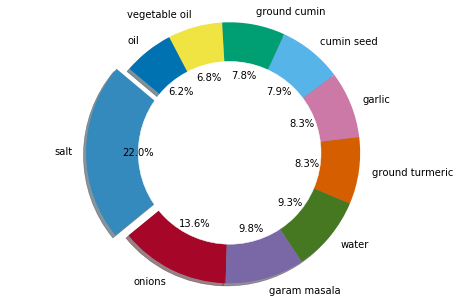

In [407]:
%matplotlib inline
#c[0].value_counts().plot(kind='pie')

# Data to plot
labels = c[0]
sizes = c[1]
explode = (0.1, 0, 0, 0,0,0,0,0,0,0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=140)
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.tight_layout(pad=0)
 
plt.axis('equal')
plt.show()

In [408]:
#changing it to a dataframe to see top 5 ingrediants of all the countries 
Cuisine=["greece","US","Philippines","India","Jamaica","Spain","Italy","Mexico","China","britain","Thailand","Vietnam","Jamaica","brazil","france","japan","ireland","korea","morocco","russia"]
top5 = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(5)] for cuisine in counters],
            index=[cuisine for cuisine in Cuisine],
            columns=['top{}'.format(i) for i in range(1, 6)])
#top5["Country"]=[cuisine for cuisine in Cuisine]
print(top5)

                   top1               top2               top3  \
greece             salt          olive oil      dried oregano   
US                 salt             butter  all-purpose flour   
Philippines        salt             garlic              water   
India              salt             onions       garam masala   
Jamaica            salt             onions              water   
Spain              salt          olive oil      garlic cloves   
Italy              salt          olive oil      garlic cloves   
Mexico             salt             onions       ground cumin   
China         soy sauce         sesame oil               salt   
britain            salt  all-purpose flour             butter   
Thailand     fish sauce             garlic               salt   
Vietnam      fish sauce              sugar               salt   
Jamaica            salt             onions             garlic   
brazil             salt             onions          olive oil   
france             salt  

In [409]:
#saving the top 5 ingredients to a csv file for use in the network visualization.
top5_value = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(5)] for cuisine in counters],
             index=[cuisine for cuisine in Cuisine],
             columns=['top{}'.format(i) for i in range(1, 6)])
top5_value.columns.name = 'Country'

#print(top5_value)
top5_value=top5_value.stack()
top5_value.name = 'cuisine'
top5_value.reset_index()
top5_value.to_csv("top5 ingrediants country wise.csv")

In [130]:
%%HTML
<div class='tableauPlaceholder' id='viz1524715194408' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;co&#47;countrywisetopingredients&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='countrywisetopingredients&#47;Dashboard1' /><param name='tabs' value='yes' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;co&#47;countrywisetopingredients&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1524715194408');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='100%';vizElement.style.minHeight='830px';vizElement.style.maxHeight=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.minWidth='1500px';vizElement.style.maxWidth='100%';vizElement.style.minHeight='847px';vizElement.style.maxHeight=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.minWidth='1500px';vizElement.style.maxWidth='100%';vizElement.style.minHeight='847px';vizElement.style.maxHeight=(divElement.offsetWidth*1.77)+'px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [410]:
# Auxiliar function for cleaning
stemmer = WordNetLemmatizer()
traindf['ingredients_clean_string'] = [','.join(z).strip() for z in traindf['ingredients']]  

# Remove Punctuation
traindf['ingredients_string'] = [' '.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) 
                                           for line in lists]).strip() for lists in traindf['ingredients']]  
#lower case
traindf['ingredients_clean_string']  = [ str.lower(i) for i in traindf['ingredients_clean_string'] ]
## Remove digits
traindf['ingredients_clean_string']  = [ i for i in traindf['ingredients_clean_string'] if not i.isdigit() ]
# Stem ingredients
traindf['ingredients_clean_string']  = [ stemmer.lemmatize(i) for i in traindf['ingredients_clean_string'] ]
#Lemmatization 
traindf['ingredients_clean_string'] = traindf['ingredients_clean_string'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
#remove white space
traindf['ingredients_clean_string'] = [" ".join(i.split())for i in traindf['ingredients_clean_string']]

def replacing(i):
        i = i.replace('&', '').replace('(', '').replace(')','')
        i = i.replace('\'', '').replace('\\', '')
        i = i.replace('.', '').replace('%', '').replace('/','')
        i = i.replace('"', '')
        
        return i
# Replacing characters
traindf['ingredients_clean_string']  = [ replacing(i) for i in traindf['ingredients_clean_string'] ]

In [411]:
traindf.head()

,cuisine,id,ingredients,ingredients_clean_string,ingredients_string
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce,black olives,grape tomatoes,ga...",romaine lettuce black olives grape tomatoes ga...
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour,ground pepper,salt,tomatoes,ground...",plain flour ground pepper salt tomato ground b...
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs,pepper,salt,mayonaise,cooking oil,green c...",egg pepper salt mayonaise cooking oil green ch...
3,indian,22213,"[water, vegetable oil, wheat, salt]","water,vegetable oil,wheat,salt",water vegetable oil wheat salt
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...","black pepper,shallots,cornflour,cayenne pepper...",black pepper shallot cornflour cayenne pepper ...


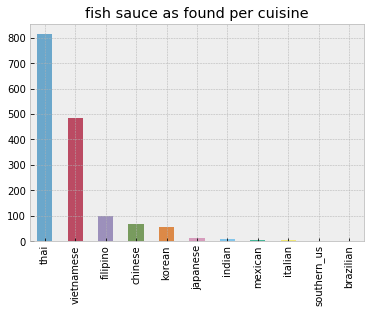

In [412]:
indices = traindf['ingredients_clean_string'].str.contains('fish sauce')
traindf[indices]['cuisine'].value_counts().plot(kind='bar',
                                                 title='fish sauce as found per cuisine',alpha=0.7)

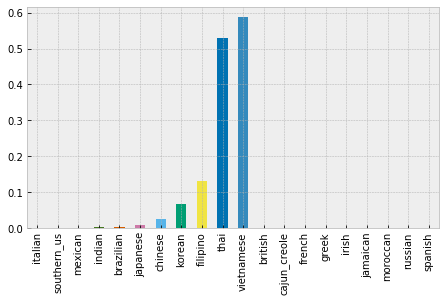

In [413]:
relative_freq = (traindf[indices]['cuisine'].value_counts() / traindf['cuisine'].value_counts())
relative_freq.sort_values(inplace=True)
relative_freq.plot(kind='bar')
plt.tight_layout(pad=0)

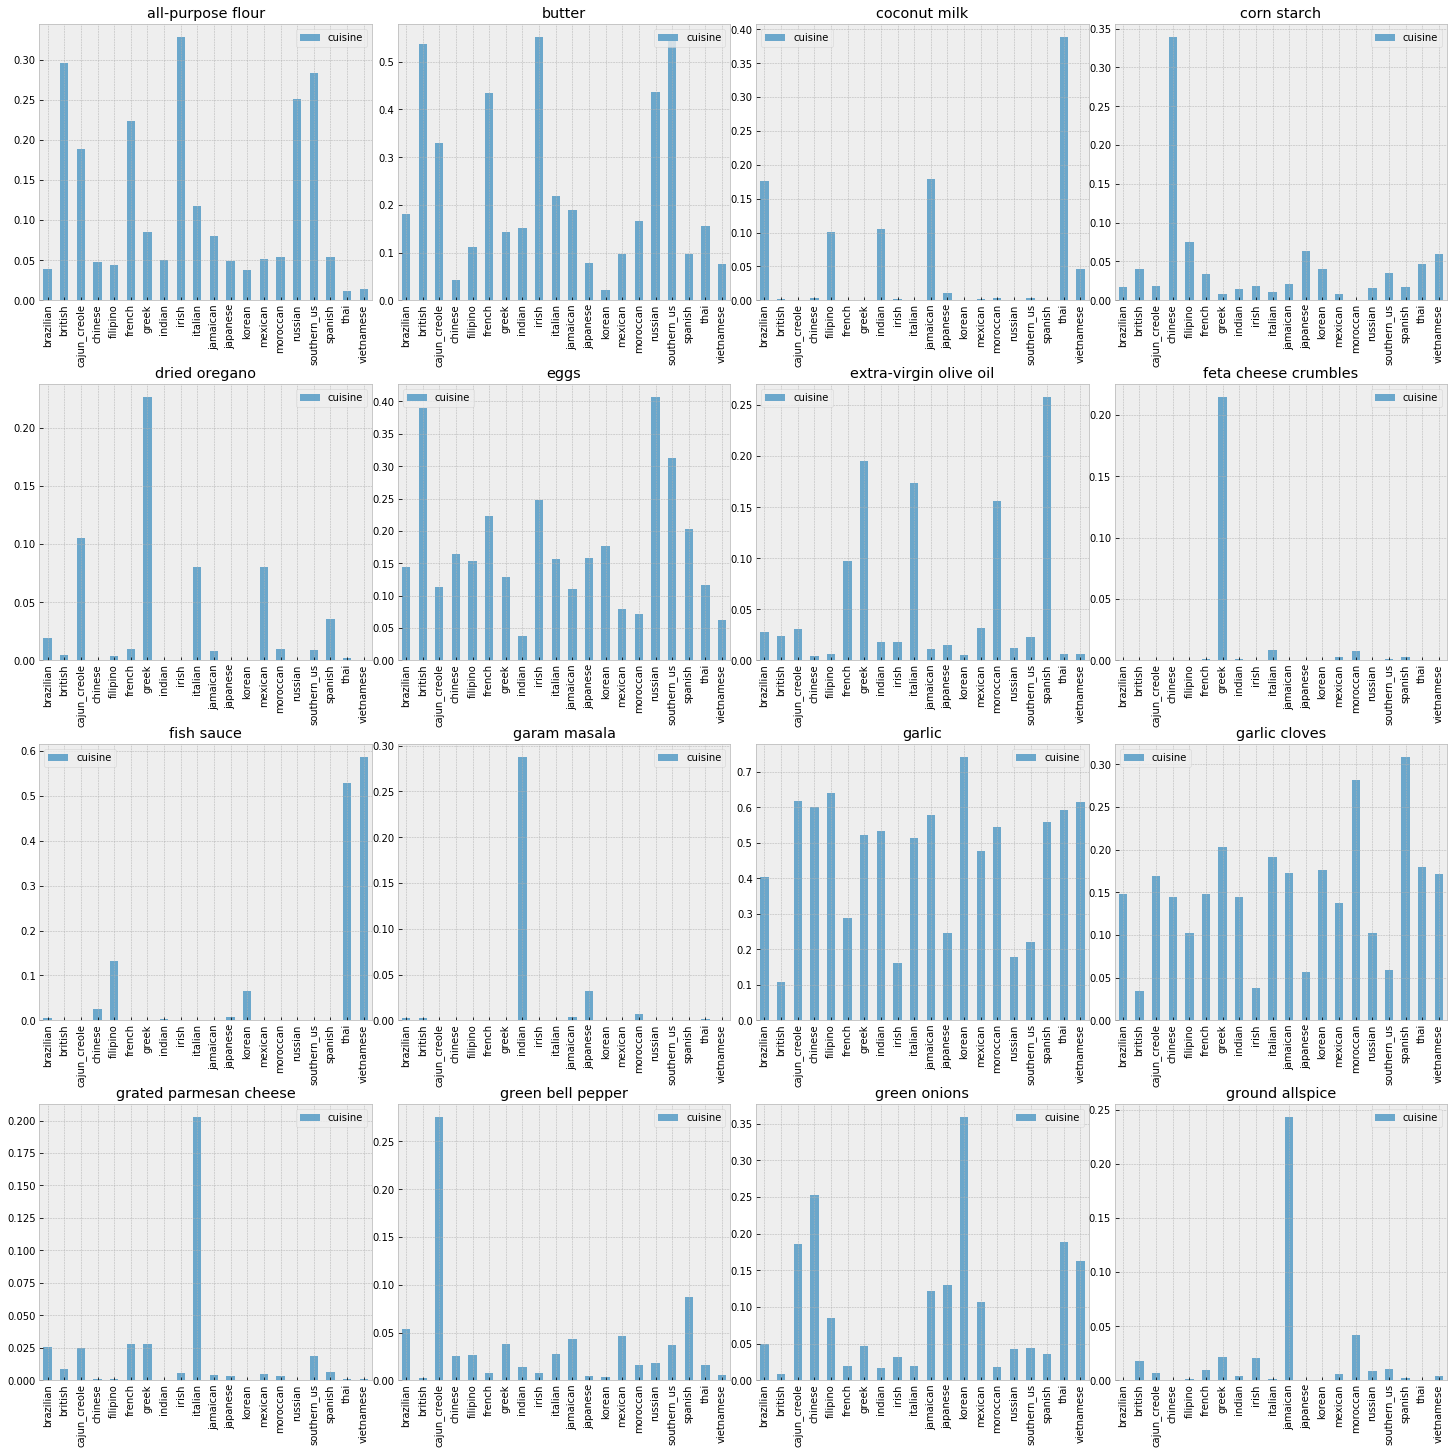

In [296]:
unique = np.unique(top5.values.ravel())
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for ingredient, ax_index in zip(unique, range(16)):
    indices = traindf['ingredients_clean_string'].str.contains(ingredient)
    relative_freq = (traindf[indices]['cuisine'].value_counts() / traindf['cuisine'].value_counts())
    v= pd.DataFrame(relative_freq)
    v.plot(kind='bar', ax=axes.ravel()[ax_index], fontsize=10, title=ingredient,alpha=0.7)
    plt.tight_layout(pad=0)
    plt.savefig("top ingredients country wise.png")

In [414]:
unique = np.unique(top5.values.ravel())
for ingredient, ax_index in zip(unique, range(16)):
    indices = traindf['ingredients_clean_string'].str.contains(ingredient)
    print(indices)

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14        True
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27        True
28       False
29       False
         ...  
39744    False
39745    False
39746    False
39747    False
39748     True
39749    False
39750    False
39751    False
39752    False
39753    False
39754    False
39755    False
39756     True
39757    False
39758    False
39759    False
39760    False
39761    False
39762    False
39763    False
39764    False
39765    False
39766    False
39767    False
39768    False
39769     True
39770    False
39771    False
39772    False
39773    False
Name: ingredients_clean_string, Length: 39774, dtype: bool
0        False
1        Fa

In [208]:
#ngram
from textblob import TextBlob
TextBlob(traindf['ingredients_clean_string'][0]).ngrams(3)

[WordList(['romaine', 'lettuce', 'black']),
 WordList(['lettuce', 'black', 'olives']),
 WordList(['black', 'olives', 'grape']),
 WordList(['olives', 'grape', 'tomatoes']),
 WordList(['grape', 'tomatoes', 'garlic']),
 WordList(['tomatoes', 'garlic', 'pepper']),
 WordList(['garlic', 'pepper', 'purple']),
 WordList(['pepper', 'purple', 'onion']),
 WordList(['purple', 'onion', 'seasoning']),
 WordList(['onion', 'seasoning', 'garbanzo']),
 WordList(['seasoning', 'garbanzo', 'beans']),
 WordList(['garbanzo', 'beans', 'feta']),
 WordList(['beans', 'feta', 'cheese']),
 WordList(['feta', 'cheese', 'crumbles'])]

In [415]:
#Term frequency
#TF = (Number of times term T appears in the particular row) / (number of terms in that row)
tf1 = (traindf['ingredients_clean_string'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['ing','tf']
tf1

,ing,tf
0,plain,1
1,black,1
2,"pepper,thyme,eggs,green",1
3,"flour,ground",1
4,oil,1
5,"tomatoes,yellow",1
6,"pepper,salt,tomatoes,ground",1
7,corn,1
8,"meal,milk,vegetable",1


In [416]:
#idf
#IDF = log(N/n), where, N is the total number of rows and n is the number of rows in which the word was present.
for i,word in enumerate(tf1['ing']):
  tf1.loc[i, 'idf'] = np.log(traindf.shape[0]/(len(traindf[traindf['ingredients_clean_string'].str.contains(word)])))

tf1

,ing,tf,idf
0,plain,1,3.814462
1,black,1,1.354181
2,"pepper,thyme,eggs,green",1,10.590969
3,"flour,ground",1,5.038009
4,oil,1,0.620337
5,"tomatoes,yellow",1,6.356862
6,"pepper,salt,tomatoes,ground",1,10.590969
7,corn,1,1.831143
8,"meal,milk,vegetable",1,10.590969


In [417]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1

,ing,tf,idf,tfidf
0,plain,1,3.814462,3.814462
1,black,1,1.354181,1.354181
2,"pepper,thyme,eggs,green",1,10.590969,10.590969
3,"flour,ground",1,5.038009,5.038009
4,oil,1,0.620337,0.620337
5,"tomatoes,yellow",1,6.356862,6.356862
6,"pepper,salt,tomatoes,ground",1,10.590969,10.590969
7,corn,1,1.831143,1.831143
8,"meal,milk,vegetable",1,10.590969,10.590969


In [212]:
testdf = pd.read_json("test_1.json") 
testdf['ingredients_clean_string'] = [' , '.join(z).strip() for z in testdf['ingredients']]
testdf['ingredients_string'] = [' '.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in testdf['ingredients']]       


In [418]:

#Remove Stopwords
corpustr = traindf['ingredients_string']
vectorizertr = TfidfVectorizer(stop_words='english',
                             ngram_range = ( 1 , 1 ),analyzer="word", 
                             max_df = .35 , binary=False , token_pattern=r'\w+' , sublinear_tf=False)
tfidftr=vectorizertr.fit_transform(corpustr).todense()
corpusts = testdf['ingredients_string']
vectorizerts = TfidfVectorizer(stop_words='english')
tfidfts=vectorizertr.transform(corpusts)

predictors_tr = tfidftr
targets_tr = traindf['cuisine']
predictors_ts = tfidfts

parameters = {'C':[1, 10]}
clf = LinearSVC(C = 0.5)
classifier = grid_search.GridSearchCV(clf, parameters)

classifier=classifier.fit(predictors_tr,targets_tr)
print(classifier)

predictions=classifier.predict(predictors_ts)

testdf['cuisine'] = predictions
testdf = testdf.sort_values('id' , ascending=True)

testdf[['cuisine','ingredients_clean_string' ]].to_csv("submission_1.csv")
#nx.write_gml(testdf[['id' , 'ingredients_clean_string' , 'cuisine' ]],"submission_1.csv")

print("Result in submission_1 CSV")

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1, param_grid={'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)
Result in submission_1 CSV


In [340]:
# get the accuracy
#print (accuracy_score(testdf['cuisine'], predictions))

In [419]:
from sklearn.datasets import make_classification
clf = LinearSVC(random_state=0)
clf.fit(predictors_tr,targets_tr)
print(clf.coef_)
print("\n",clf.intercept_)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -8.10784187e-02
  -1.23769950e-01 -2.18221609e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.59780260e-02
   0.00000000e+00  1.03325269e-03]
 [ 0.00000000e+00  0.00000000e+00  9.14105907e-01 ... -5.42101086e-20
  -1.28800432e-01 -3.69519662e-01]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.59213787e-01
  -1.65103015e-01 -7.40025788e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -2.42923755e-03  2.70162941e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.86936142e-02
  -1.76017151e-02 -7.37288943e-01]]

 [-1.58729475 -1.30867064 -1.49027812 -1.27122892 -1.17409109 -0.85006389
 -1.49135382 -1.03271371 -1.23439838 -0.51589109 -1.71685901 -1.01616896
 -1.46419145 -0.78109087 -1.66255383 -1.40252824 -1.00322189 -1.3053644
 -1.69222789 -1.44400882]


In [420]:
#Naive Baise
model = MultinomialNB(fit_prior=True) 
model.fit(predictors_tr,targets_tr)  # train the model
y_pred_class = model.predict(predictors_tr)

from sklearn import metrics
metrics.accuracy_score(targets_tr, y_pred_class)

0.7017901141449188

In [421]:
#We will use scikit-learn to perform our classification. First, we will need to encode our features to a matrix that 
#the machine learning algorithms in scikit learn can use. This is done using a count vectorizer:
cv = CountVectorizer()
X = cv.fit_transform(traindf['ingredients_clean_string'].values)
print(X.shape)
##Each feature gets assigned a column number, which is assigned a 1 or a 0 depending on the presence or not of the ingredient.
print(list(cv.vocabulary_.keys())[:20])
#Now that we have our feature matrix, we still need to encode the labels that represent the cuisine of each recipe.
#This is done with a label encoder:
enc = LabelEncoder()
y = enc.fit_transform(traindf.cuisine)
#The variable y is now a vector with number instead of strings for each cuisine:
print(y[:100])
#We can check the result by inspecting the encoders classes:
print(enc.classes_)

(39774, 3081)
['romaine', 'lettuce', 'black', 'olives', 'grape', 'tomatoes', 'garlic', 'pepper', 'purple', 'onion', 'seasoning', 'garbanzo', 'beans', 'feta', 'cheese', 'crumbles', 'plain', 'flour', 'ground', 'salt']
[ 6 16  4  7  7 10 17  9 13  9  9  3  9 13  9  7  1  9 18 19 18 13 16  3
  9  3  2  9  3 13  9  2 13 18  9  2  9  4 16 16  9  0 13  7 13  3  5 16
 16 16 11 16  9 16  9 10 11  7  9  8 18 18  7 10  9 18 12  5  5 16 17  7
 14  9  9 14 14 19 11 13  2 16  5  7  7  9  9  7 12 17  9 16 16  6 13 13
 16  7  9  9]
['brazilian' 'british' 'cajun_creole' 'chinese' 'filipino' 'french'
 'greek' 'indian' 'irish' 'italian' 'jamaican' 'japanese' 'korean'
 'mexican' 'moroccan' 'russian' 'southern_us' 'spanish' 'thai'
 'vietnamese']


In [220]:
#split the dataset so that we can also test our classifier on data that he hasn't seen before:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#train a logistic regression:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

print(logistic.score(X_test, y_test))

0.789566310496543


In [423]:

def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold cross validation iterator
    cv = KFold(len(y), K, shuffle=True, random_state=0)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=cv)
    print (scores)
    print ("Mean score: {0:.3f} (+/-{1:.3f})".format(np.mean(scores), sem(scores)))
evaluate_cross_validation(logistic, X, y, 5)

[0.79057197 0.78730358 0.78265242 0.79170333 0.78036208]
Mean score: 0.787 (+/-0.002)


In [424]:

y_pred = logistic.predict(X_test)
print(classification_report(y_test, y_pred, target_names=Cuisine))

             precision    recall  f1-score   support

     greece       0.72      0.56      0.63        79
         US       0.52      0.41      0.45       155
Philippines       0.76      0.71      0.73       298
      India       0.82      0.86      0.84       514
    Jamaica       0.74      0.62      0.68       165
      Spain       0.62      0.60      0.61       546
      Italy       0.78      0.72      0.75       222
     Mexico       0.85      0.92      0.88       594
      China       0.61      0.45      0.52       139
    britain       0.79      0.89      0.84      1580
   Thailand       0.78      0.68      0.73        92
    Vietnam       0.86      0.69      0.76       267
    Jamaica       0.83      0.77      0.79       162
     brazil       0.92      0.92      0.92      1346
     france       0.87      0.73      0.79       170
      japan       0.72      0.49      0.58       102
    ireland       0.71      0.80      0.75       866
      korea       0.63      0.46      0.53   

In [430]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

In [520]:
# Use the forest's predict method on the test data
#np.seterr(divide='ignore', invalid='ignore')
pred = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(pred - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = (100 * (errors / y_test))
mape=pd.DataFrame(mape)
mape=mape.replace([np.inf, -np.inf], np.nan)
mape=mape.dropna()
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy[0], 2), '%.')

Mean Absolute Error: 2.25 degrees.
Accuracy: 55.97 %.


In [182]:
testdf.head()

,id,ingredients,ingredients_clean_string,ingredients_string,cuisine
4987,5,"[mushrooms, chopped onion, tomato sauce, chees...","mushrooms , chopped onion , tomato sauce , che...",mushroom chopped onion tomato sauce cheese dri...,mexican
9232,7,"[minced garlic, brown rice, sour cream, chicke...","minced garlic , brown rice , sour cream , chic...",minced garlic brown rice sour cream chicken re...,indian
9638,11,"[lime juice, sesame oil, garlic cloves, fish s...","lime juice , sesame oil , garlic cloves , fish...",lime juice sesame oil garlic cloves fish sauce...,vietnamese
4927,12,"[sugar, vanilla extract, corn starch, coffee g...","sugar , vanilla extract , corn starch , coffee...",sugar vanilla extract corn starch coffee granu...,italian
3280,13,"[frozen pie crust, bourbon whiskey, powdered s...","frozen pie crust , bourbon whiskey , powdered ...",frozen pie crust bourbon whiskey powdered suga...,southern_us


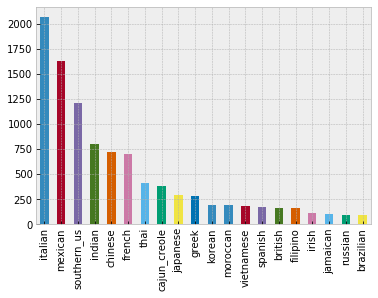

In [373]:
fig=testdf['cuisine'].value_counts().plot(kind='bar')

In [177]:
recipe = [ str.lower(i) for recipe in testdf['ingredients'] for i in recipe ]
## Remove digits
recipe = [ i for recipe in testdf['ingredients'] for i in recipe if not i.isdigit() ]
# Stem ingredients
recipe = [ stemmer.lemmatize(i) for recipe in testdf['ingredients'] for i in recipe ]
#remove white space
recipe= [" ".join(i.split())for recipe in testdf['ingredients'] for i in recipe ]

def replacing(i):
        i = i.replace('&', '').replace('(', '').replace(')','')
        i = i.replace('\'', '').replace('\\', '').replace(',','')
        i = i.replace('.', '').replace('%', '').replace('/','')
        i = i.replace('"', '')
        
        return i
# Replacing characters
recipe = [ replacing(i) for recipe in testdf['ingredients'] for i in recipe ]


In [375]:
# The number of times each ingredient is used is stored in the 'sumbags' dictionary
bags_of_words = [ Counter(recipe) for recipe in testdf.ingredients ]
sumbags = sum(bags_of_words,Counter())

In [376]:
bags_of_words

[Counter({'cheese': 1,
          'chili powder': 1,
          'chopped onion': 1,
          'dried oregano': 1,
          'garlic cloves': 1,
          'lean ground turkey': 1,
          'mushrooms': 1,
          'salt': 1,
          'tomato sauce': 1,
          'tortillas': 1}),
 Counter({'(14.5 oz.) diced tomatoes': 1,
          'brown rice': 1,
          'celery': 1,
          'chicken': 1,
          'chickpeas': 1,
          'fresh ginger': 1,
          'garam masala': 1,
          'ground cardamom': 1,
          'ground cayenne pepper': 1,
          'ground cumin': 1,
          'ground turmeric': 1,
          'minced garlic': 1,
          'olive oil': 1,
          'onions': 1,
          'red lentils': 1,
          'sour cream': 1}),
 Counter({'button mushrooms': 1,
          'cilantro': 1,
          'extra-virgin olive oil': 1,
          'fish sauce': 1,
          'garlic cloves': 1,
          'green onions': 1,
          'jalapeno chilies': 1,
          'large shrimp': 1,
       

{'salt': 4485, 'onions': 2036, 'olive oil': 1917, 'water': 1836, 'garlic': 1791}


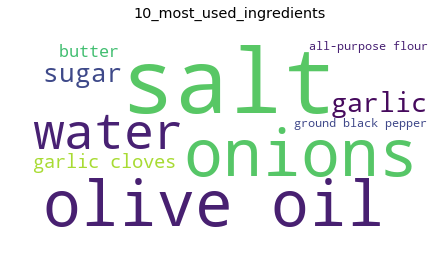

In [382]:
# Finally, plot the 10 most used ingredients
fig1 = pd.DataFrame(sumbags, index=[0]).transpose()[0].sort_values(ascending=False, inplace=False)[:10]
#fig.savefig('10_most_used_ingredients.jpg')
print(dict(Counter(sumbags).most_common(5)))
wordcloud = WordCloud(background_color="white",max_font_size=90, random_state=42).generate_from_frequencies(fig1)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.title('10_most_used_ingredients\n')
plt.tight_layout(pad=0)
plt.show()


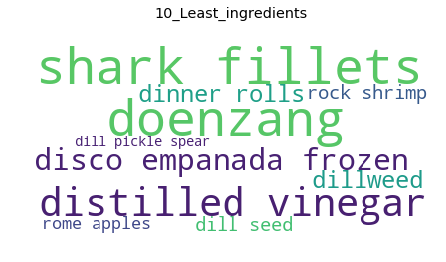

In [192]:
# Finally, plot the 10 most used ingredients
fig2 = pd.DataFrame(sumbags, index=[0]).transpose()[0].sort_values(ascending=True, inplace=False)[:10]
#fig.savefig('10_most_used_ingredients.jpg')
wordcloud = WordCloud(background_color="white",max_font_size=90, random_state=42).generate_from_frequencies(fig2)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.title('10_Least_ingredients\n')
plt.tight_layout(pad=0)
plt.show()

In [4]:
import csv

In [68]:
a = pd.read_csv("top5 ingrediants country wise.csv")
a.columns=['Cuisine','Count','ingredients']
a.head(10)

,Cuisine,Count,ingredients
0,greek,0,salt
1,greek,1,olive oil
2,greek,2,dried oregano
3,greek,3,garlic cloves
4,greek,4,feta cheese crumbles
5,southern_us,0,salt
6,southern_us,1,butter
7,southern_us,2,WHEAT FLOUR
8,southern_us,3,sugar
9,southern_us,4,large eggs


In [293]:
#A confusion matrix is a technique for summarizing the performance of a classification algorithm.
from sklearn.metrics import confusion_matrix

df_confusion = confusion_matrix(y_test, logistic.predict(X_test))
df_confusion_normalized = df_confusion.astype('float') / df_confusion.sum(axis=1)[:, np.newaxis]
pd.crosstab(y_test, logistic.predict(X_test), rownames=['True'], colnames=['Predicted'], margins=True).apply(lambda r: 100.0 * r/r.sum())


Predicted,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,All
True,,,,,,,,,,,,,,,,,,,,,
0,36.507937,0.438596,0.190114,0.000000,1.2,0.423729,0.000000,0.157233,0.000000,0.144259,...,0.000000,0.000000,0.379651,0.000000,0.000000,0.207039,0.967742,0.488599,0.000000,0.527970
1,0.793651,28.508772,0.380228,0.000000,0.4,2.033898,0.229358,0.471698,4.736842,0.461627,...,0.195312,0.349650,0.037965,0.000000,2.857143,1.449275,0.322581,0.000000,0.000000,1.018228
2,0.000000,0.877193,39.543726,0.089445,0.4,1.016949,0.000000,0.078616,0.000000,0.461627,...,0.000000,0.000000,0.303721,0.000000,0.000000,2.173913,0.645161,0.000000,0.000000,1.841609
3,1.587302,0.438596,0.570342,40.161002,3.2,0.508475,0.000000,0.157233,0.526316,0.259665,...,2.734375,4.545455,0.075930,0.000000,0.000000,0.155280,0.000000,1.954397,3.017241,3.343809
4,2.380952,0.000000,0.000000,0.894454,37.2,0.593220,0.000000,0.000000,0.000000,0.144259,...,0.390625,0.000000,0.379651,0.000000,0.000000,0.310559,0.000000,0.651466,2.155172,0.911376
5,0.000000,3.508772,0.570342,0.000000,0.0,29.322034,0.458716,0.471698,2.105263,2.971725,...,0.390625,0.000000,0.037965,0.704225,4.285714,1.708075,4.193548,0.000000,0.000000,3.331238
6,0.000000,0.877193,0.190114,0.000000,0.0,1.101695,41.743119,0.471698,0.000000,1.182920,...,0.000000,0.000000,0.113895,1.056338,0.714286,0.207039,0.645161,0.000000,0.000000,1.621622
7,1.587302,0.438596,0.190114,0.178891,0.4,0.423729,0.229358,42.610063,0.000000,0.115407,...,0.781250,0.000000,0.455581,4.225352,0.000000,0.362319,0.000000,0.651466,0.431034,3.771213
8,0.000000,5.701754,0.000000,0.000000,0.0,1.525424,0.458716,0.235849,35.789474,0.317369,...,0.000000,0.000000,0.037965,0.704225,1.428571,1.449275,0.322581,0.000000,0.000000,0.936518


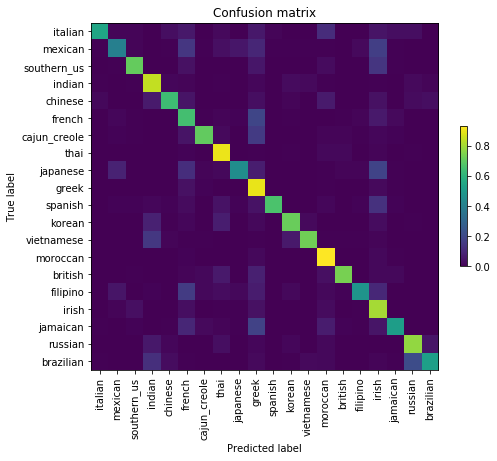

In [270]:

def plot_confusion_matrix(df_confusion,title='Confusion matrix'):
    plt.figure(figsize=(7, 7))
    plt.imshow(cm_normalized, interpolation='nearest')
    plt.title(title)
    plt.colorbar(shrink=0.3)
    cuisines = traindf['cuisine'].value_counts().index
    tick_marks = np.arange(len(cuisines))
    plt.xticks(tick_marks, cuisines, rotation=90)
    plt.yticks(tick_marks, cuisines)
    plt.tight_layout(pad=0)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(df_conf_norm)

In [397]:
y_test.shape

(20,)